In [1]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, PandasTools, Draw
from rdkit.Chem.Draw import IPythonConsole

df = pd.read_csv("data/hydrocarbons.csv")
df.head()

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density@20å¡C*,Flash point,Autoignition temp
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN


* take iupac names and generate dataset with smiles, mp, bp, etc

In [2]:
def fetch_smiles_by_name(name):
    error = None
    baseurl = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/'
    rpath = name + '/property/CanonicalSMILES/JSON'
    url = baseurl + rpath
    r = requests.get(url)
    if r.status_code == 200:
        dat = r.json()
        smiles = dat['PropertyTable']['Properties'][0]['CanonicalSMILES']
    elif r.status_code == 503:    # recursive retry if server is busy
        smiles, error = fetch_smiles_by_name(name)
    else:
        print(f"problem retrieving data for {name}")
        error = {name: r.status_code}
        smiles = ''
        
    return smiles, error

In [3]:
smiles_set = []
errors = {}
for name in df['IUPAC name']:
    print(f"getting PubChem data for {name}...")
    smiles, error = fetch_smiles_by_name(name)
    smiles_set += [smiles]
    if error:
        errors.update(error)

getting PubChem data for 2,2,4-Trimethylpentane...
getting PubChem data for Phenanthrene...
getting PubChem data for Anthracene...
getting PubChem data for 1-methylanthracene...
getting PubChem data for 2-methylanthracene...
getting PubChem data for 1,2,3,4-tetrahydro-naphthalene...
getting PubChem data for 1,2,3,4-tetrahydro-5-methyl-naphthalene...
getting PubChem data for Benzophenanthrene...
getting PubChem data for Chrysene...
getting PubChem data for Triphenylene...
getting PubChem data for Pyrene...
getting PubChem data for Methane...
getting PubChem data for Ethane...
getting PubChem data for Propane...
getting PubChem data for N-butane...
getting PubChem data for N-pentane...
getting PubChem data for N-hexane...
getting PubChem data for N-heptane...
getting PubChem data for N-octane...
getting PubChem data for N-nonane...
getting PubChem data for N-decane...
getting PubChem data for N-undecane...
getting PubChem data for N-dodecane...
getting PubChem data for N-tridecane...
get

getting PubChem data for 1-heptadecene...
getting PubChem data for 1-octadecene...
getting PubChem data for 1-nonadecene...
getting PubChem data for 1-docosene...


In [4]:
df['Canonical SMILES'] = smiles_set
df = df.copy()
df.head()

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density@20å¡C*,Flash point,Autoignition temp,Canonical SMILES
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396,CC(C)CC(C)(C)C
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450,C1=CC=C2C(=C1)C=CC3=CC=CC=C32
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN,C1=CC=C2C=C3C=CC=CC3=CC2=C1
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN,CC1=CC=CC2=CC3=CC=CC=C3C=C12
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN,CC1=CC2=CC3=CC=CC=C3C=C2C=C1


* create mol objects with smiles

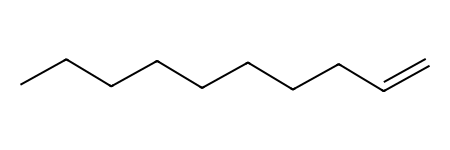

In [5]:
mol_list = []
for smiles in df['Canonical SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    mol_list += [mol]

mol_list[183]

* calculate autocorr2D descriptors
* add them to the dataframe

In [6]:
autocorr2d_set = []
for mol in mol_list:
    autocorr2d_set += [Chem.rdMolDescriptors.CalcAUTOCORR2D(mol)]

for i in range(len(autocorr2d_set[0])):
    col_vals = [x[i] for x in autocorr2d_set]
    col_name = f'AutoCorr2D-{i+1}'
    df[col_name] = col_vals
    df = df.copy()    # jupyter gives a performance warning that the dataframe is highly fragmented without this

df.head()

,Class of hydrocarbon,IUPAC name,Melting point,Boiling point,Density@20å¡C*,Flash point,Autoignition temp,Canonical SMILES,AutoCorr2D-1,AutoCorr2D-2,...,AutoCorr2D-183,AutoCorr2D-184,AutoCorr2D-185,AutoCorr2D-186,AutoCorr2D-187,AutoCorr2D-188,AutoCorr2D-189,AutoCorr2D-190,AutoCorr2D-191,AutoCorr2D-192
0,Trimetylalkane,"2,2,4-Trimethylpentane",-107.0,99.0,0.69,NaN,396,CC(C)CC(C)(C)C,0.000,0.000,...,0.0,0.0,1.874,0.227,2.523,0.000,0.000,0.000,0.000,0.00
1,Triaromatics,Phenanthrene,99.0,338.0,1.18,171,>450,C1=CC=C2C(=C1)C=CC3=CC=CC=C32,2.833,3.135,...,0.0,0.0,0.853,1.448,1.241,0.853,0.455,0.000,0.000,0.00
2,Triaromatics,Anthracene,216.0,341.0,1.2825,NaN,NaN,C1=CC=C2C=C3C=CC=CC3=CC2=C1,2.833,3.135,...,0.0,0.0,1.138,1.241,0.867,1.300,0.910,0.000,0.000,0.00
3,Triaromatics,1-methylanthracene,86.0,342.0,1.04799,NaN,NaN,CC1=CC=CC2=CC3=CC=CC=C3C=C12,2.890,3.219,...,0.0,0.0,0.828,1.069,0.899,1.167,1.123,0.938,0.960,0.00
4,Triaromatics,2-methylanthracene,209.0,340.0,1.8,NaN,NaN,CC1=CC2=CC3=CC=CC=C3C=C2C=C1,2.890,3.219,...,0.0,0.0,1.033,1.111,0.737,1.060,0.832,0.813,1.875,2.88


* set up ML algorithm to predict mp or bp using autocorr2D

In [7]:
# first, make a new dataframe dropping rows(axis=0) missing data in the Melting point column
newdf = df.dropna(axis=0, subset='Melting point')

X = newdf.iloc[:,8:]    # a slice of just the autocorr2D descriptors
Y = newdf['Melting point']

Let's look at a small subset of the descriptors and see how they correlate with the melting point.

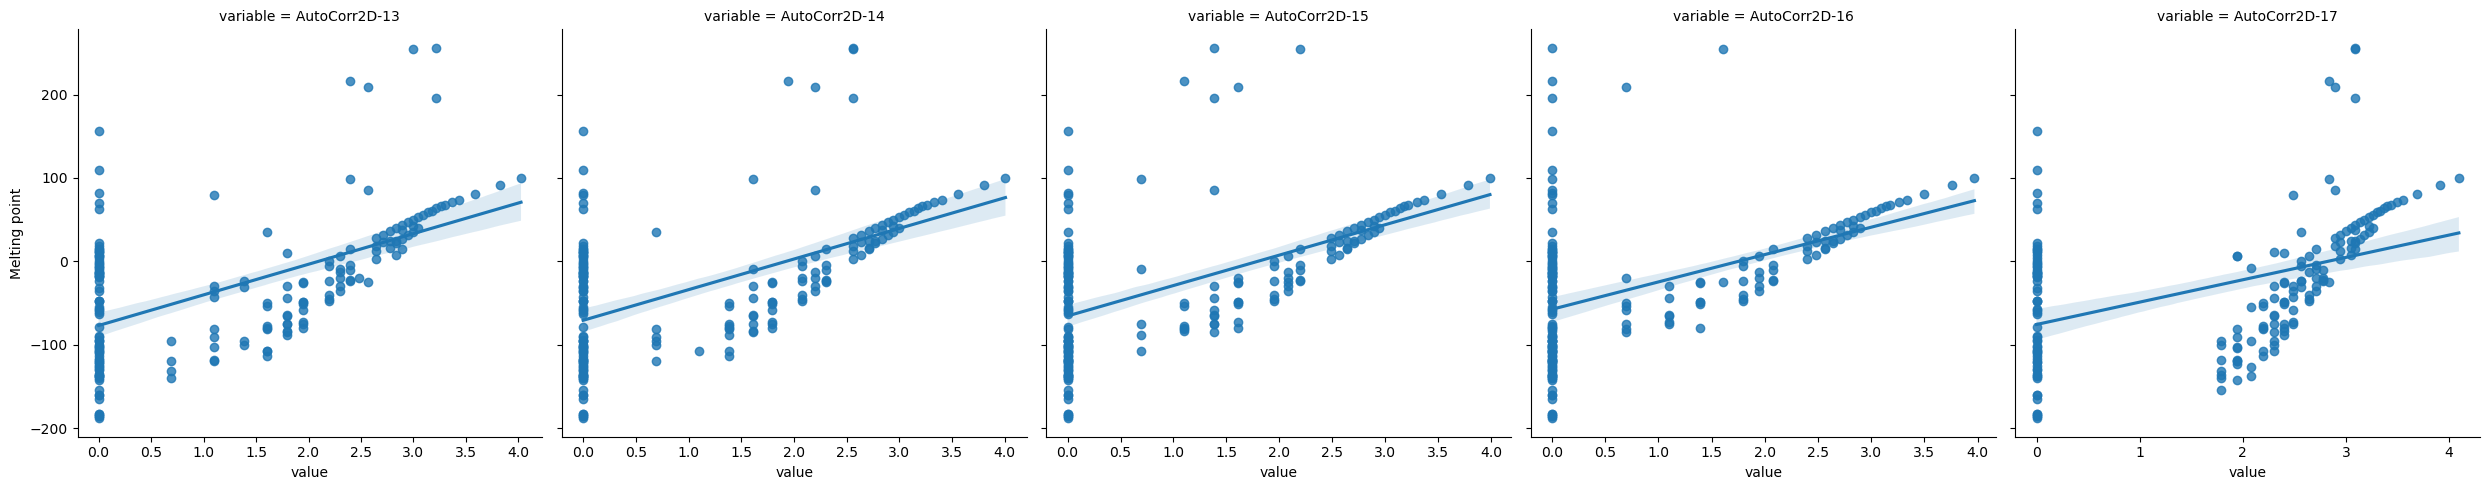

In [8]:
dat = pd.concat([Y, X.iloc[:,12:17]], axis=1)
dat_vis = dat.melt(id_vars='Melting point')
g = sns.lmplot(data=dat_vis, y="Melting point", x="value", col="variable", facet_kws={"sharex":False})

In [9]:
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [10]:
model.score(X, Y)

0.8395455514164372

In [17]:
# Create a list of Mol objects
amino_acid_supplier = Chem.SDMolSupplier('data/amino_acids/amino_acids-nat20.sdf', removeHs=False, strictParsing=False)

names = []
aa_autocorr = []
for mol in amino_acid_supplier:
    names += [mol.GetProp('_Name')]
    aa_autocorr += [Chem.rdMolDescriptors.CalcAUTOCORR2D(mol)]

columns = [f'AutoCorr2D-{num+1}' for num in range(192)]

aa_df = pd.DataFrame(aa_autocorr, index=names, columns=columns)

In [18]:
aa_df.head()

,AutoCorr2D-1,AutoCorr2D-2,AutoCorr2D-3,AutoCorr2D-4,AutoCorr2D-5,AutoCorr2D-6,AutoCorr2D-7,AutoCorr2D-8,AutoCorr2D-9,AutoCorr2D-10,...,AutoCorr2D-183,AutoCorr2D-184,AutoCorr2D-185,AutoCorr2D-186,AutoCorr2D-187,AutoCorr2D-188,AutoCorr2D-189,AutoCorr2D-190,AutoCorr2D-191,AutoCorr2D-192
Ala,2.012,2.259,2.093,0.855,0.035,0.000,0.000,0.000,1.921,2.085,...,0.000,0.000,0.974,0.462,0.917,1.918,0.000,0.000,0.000,0.000
Arg,2.694,2.946,2.861,2.596,2.461,2.336,2.275,2.112,2.599,2.842,...,0.932,0.639,1.042,0.399,0.853,1.209,0.967,1.159,1.007,0.864
Asn,2.406,2.699,2.601,2.376,2.148,0.523,0.014,0.000,2.245,2.466,...,0.000,0.000,0.949,0.505,1.192,1.272,0.657,1.691,0.000,0.000
Asp,2.413,2.719,2.601,2.402,2.180,0.380,0.007,0.000,2.217,2.431,...,0.000,0.000,0.989,0.493,1.121,1.315,0.729,1.771,0.000,0.000
Cys,2.331,2.540,2.641,2.289,0.400,0.007,0.000,0.000,2.088,2.274,...,0.000,0.000,0.994,0.554,0.886,1.633,0.893,0.000,0.000,0.000


In [19]:
y_pred = model.predict(aa_df)

In [22]:
predictions = pd.DataFrame(y_pred, index=names, columns=['Predicted Melting point'])
predictions

,Predicted Melting point
Ala,2.924248e+13
Arg,3.518120e+13
Asn,3.414649e+13
Asp,2.932485e+13
Cys,1.942682e+13
Gln,3.154700e+13
Glu,2.740849e+13
Gly,2.222781e+13
His,2.859662e+13
Ile,4.655265e+13


* view the results, determine best descriptors